In [ ]:
!pip install numpy scipy matplotlib opencv-python scikit-image

Diffusion Detection Score: 75.00%

Detected Characteristics:
- High-Frequency Noise: Detected
- Sensor Noise (PRNU): Detected
- Saturation Distribution: Not Detected
- Edge Consistency: Detected

Moderate probability of being diffusion generated


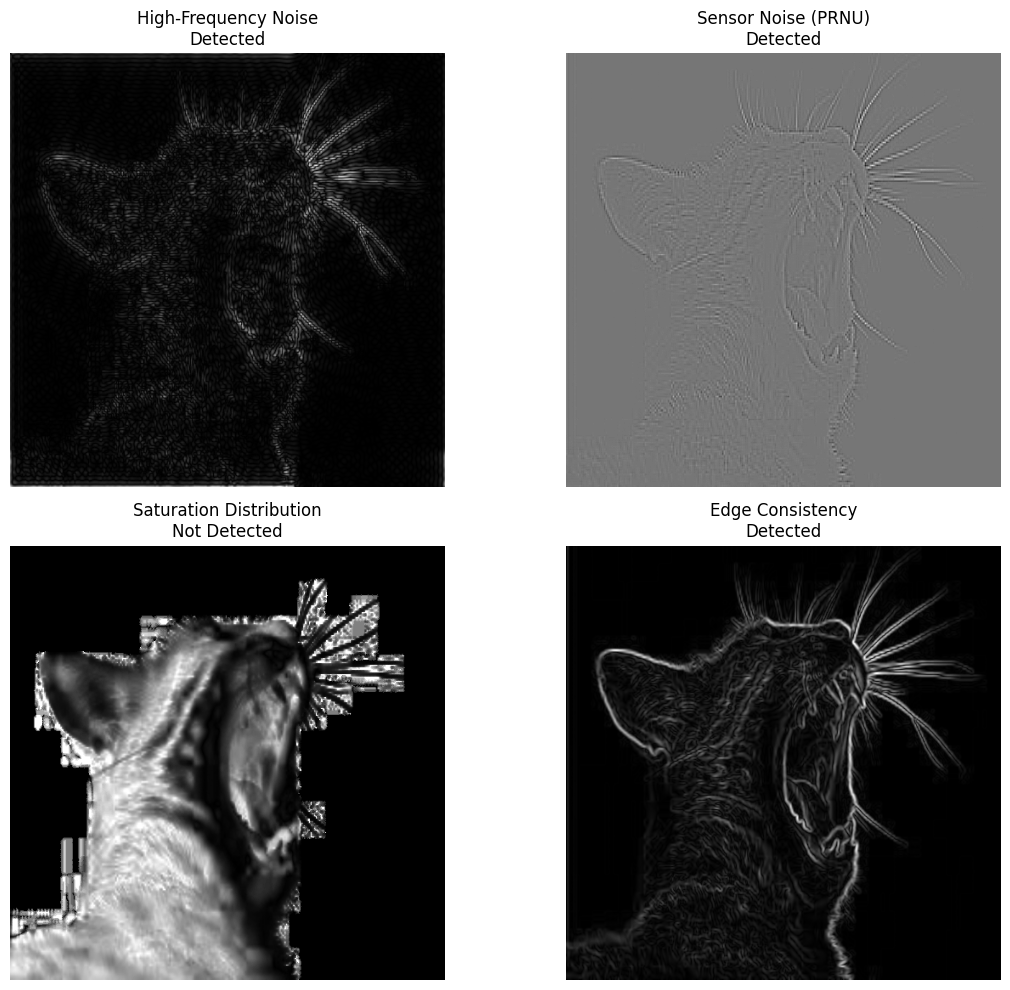

In [ ]:
import cv2
import numpy as np
from scipy.fft import fft2, fftshift
from scipy.stats import entropy, kurtosis, skew
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.resize(image, (512, 512)), cv2.resize(gray, (512, 512))

def check_high_frequency_noise(gray_img):
    # Apply a high-pass filter to extract high-frequency components
    f_transform = fft2(gray_img)
    f_shift = fftshift(f_transform)
    rows, cols = gray_img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    r = 50  # Radius of low-frequency area to block
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= r*r
    mask[mask_area] = 0
    f_shift_filtered = f_shift * mask
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    img_back = np.abs(np.fft.ifft2(f_ishift))

    # Analyze the entropy of the high-frequency image
    hist, _ = np.histogram(img_back.flatten(), bins=256, range=(0, 256))
    hist_norm = hist / np.sum(hist)
    hf_entropy = entropy(hist_norm + 1e-7)

    # Diffusion images may have lower high-frequency entropy
    return hf_entropy < 4.5, img_back

def check_prnu(gray_img):
    # Estimate the PRNU (sensor pattern noise)
    noise = gray_img.astype('float32') - cv2.GaussianBlur(gray_img, (3, 3), 0)
    noise_std = np.std(noise)

    # Diffusion images may have lower noise standard deviation
    return noise_std < 10.0, noise

def check_saturation_distribution(color_img):
    hsv = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)
    saturation = hsv[:, :, 1].flatten()
    # Analyze the skewness and kurtosis of the saturation channel
    sat_skewness = skew(saturation)
    sat_kurtosis = kurtosis(saturation)

    # Diffusion images may have different skewness and kurtosis
    result = (abs(sat_skewness) < 0.5) and (sat_kurtosis > 3)
    return result, hsv[:, :, 1]

def check_edge_consistency(gray_img):
    # Use Sobel operator to detect edges
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)
    angle = np.arctan2(sobely, sobelx)

    # Analyze the histogram of edge orientations
    angle_hist, _ = np.histogram(angle, bins=36, range=(-np.pi, np.pi))
    angle_hist_norm = angle_hist / np.sum(angle_hist)
    edge_entropy = entropy(angle_hist_norm + 1e-7)

    # Diffusion images may have lower edge orientation entropy
    return edge_entropy < 3.5, magnitude

def diffusion_detection(image_path):
    color_img, gray_img = load_image(image_path)

    checks = [
        ("High-Frequency Noise", check_high_frequency_noise(gray_img)),
        ("Sensor Noise (PRNU)", check_prnu(gray_img)),
        ("Saturation Distribution", check_saturation_distribution(color_img)),
        ("Edge Consistency", check_edge_consistency(gray_img)),
    ]

    detected_characteristics = sum(int(result) for name, (result, _) in checks)

    diffusion_score = float(detected_characteristics) / len(checks) * 100

    return diffusion_score, checks

def visualize_results(checks):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, (name, (result, vis_data)) in enumerate(checks):
        cmap = 'gray' if len(vis_data.shape) == 2 else None
        axes[i].imshow(vis_data, cmap=cmap)
        axes[i].set_title(f"{name}\n{'Detected' if result else 'Not Detected'}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def main(image_path):
    diffusion_score, checks = diffusion_detection(image_path)

    print(f"Diffusion Detection Score: {diffusion_score:.2f}%")
    print("\nDetected Characteristics:")
    for name, (result, _) in checks:
        print(f"- {name}: {'Detected' if result else 'Not Detected'}")

    if diffusion_score > 75:
        print("\nHigh probability of being diffusion generated")
    elif diffusion_score > 50:
        print("\nModerate probability of being diffusion generated")
    else:
        print("\nLow probability of being diffusion generated")

    visualize_results(checks)

# Example usage
image_path = "/content/cat.jpg"  # Update this with your image path
main(image_path)